In [71]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import numpy as np

*** Data Preparation ***

In [72]:
data = pd.read_csv("train.csv")
data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [73]:
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data, tf.float32)
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data)

tf.Tensor(
[[9.400000e+02 6.993220e+05 7.235440e+05 ... 6.600000e+01 1.140000e+02
  3.532370e+05]
 [9.600000e+01 6.855110e+05 8.060080e+05 ... 7.300000e+01 1.060000e+02
  2.736745e+05]
 [8.600000e+01 5.347650e+05 7.710660e+05 ... 8.900000e+01 7.000000e+01
  3.506475e+05]
 ...
 [7.500000e+01 5.720940e+05 7.145210e+05 ... 1.050000e+02 9.000000e+01
  1.248475e+05]
 [6.230000e+02 5.988760e+05 8.191610e+05 ... 7.600000e+01 1.380000e+02
  3.324785e+05]
 [9.290000e+02 5.957920e+05 7.806470e+05 ... 7.000000e+01 1.100000e+02
  3.668785e+05]], shape=(1000, 12), dtype=float32)


In [74]:
X = tensor_data[:, 3:-1]
print(X.shape)

(1000, 8)


In [75]:
y = tensor_data[:, -1]
y = tf.expand_dims(y, axis=-1)
print(y)

tf.Tensor(
[[353237. ]
 [273674.5]
 [350647.5]
 [294378.5]
 [369149. ]
 [457463. ]
 [510361.5]
 [177933.5]
 [118348.5]
 [379725. ]
 [419713. ]
 [133006.5]
 [198892. ]
 [303419. ]
 [526502.5]
 [584267.5]
 [325176. ]
 [199313.5]
 [181428.5]
 [426796.5]
 [253853.5]
 [198738. ]
 [360647.5]
 [295553.5]
 [115351. ]
 [172758.5]
 [172032.5]
 [387089. ]
 [135874. ]
 [399672. ]
 [223369.5]
 [ 80996. ]
 [390915.5]
 [ 82848. ]
 [413288. ]
 [405871. ]
 [182219.5]
 [314149. ]
 [317681.5]
 [324260. ]
 [549406. ]
 [166283. ]
 [294502.5]
 [427496.5]
 [360675. ]
 [308376.5]
 [200408.5]
 [429837.5]
 [267953.5]
 [584116.5]
 [275757. ]
 [265799.5]
 [403213.5]
 [505336.5]
 [229982. ]
 [362377. ]
 [312703. ]
 [320391.5]
 [158741.5]
 [ 97969. ]
 [174399. ]
 [406349.5]
 [333133. ]
 [422497. ]
 [187050. ]
 [313049.5]
 [125454. ]
 [506401. ]
 [500164. ]
 [458463.5]
 [153375.5]
 [122139.5]
 [230080. ]
 [295406.5]
 [528418.5]
 [528634. ]
 [375097.5]
 [322368. ]
 [446875. ]
 [474562.5]
 [479318.5]
 [468543. ]
 [539

In [76]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [77]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)


(800, 8)
(800, 1)


In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


In [80]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [82]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[ 0.26028693, -0.28141755,  0.70556676,  0.5127027 , -0.2576626 ,
        -0.7121597 , -0.92336017,  0.50934184],
       [-1.4797945 ,  0.779811  , -0.00443729,  0.86720765,  1.5308905 ,
        -1.2261702 , -0.58321947,  0.12660335],
       [ 0.8403141 , -0.718112  , -0.00443729,  0.86720765,  0.6366139 ,
        -0.09534715,  0.19424486, -1.5957198 ],
       [-1.4797945 ,  0.08122406, -0.71444136,  0.5127027 , -1.5990773 ,
        -1.6373786 , -1.3120923 , -0.9259275 ],
       [-0.31974024, -0.01352356,  1.4155709 , -0.19630711, -0.2576626 ,
         1.4466842 , -0.534628  ,  0.07876103]], dtype=float32)>

*** Linear Regression Model ***

In [97]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (8,)),
    normalizer,
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(1),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 8)                 17        
 tion)                                                           
                                                                 
 dense_16 (Dense)            (None, 128)               1152      
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
______________

In [85]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


*** Error Sanctioning ***

In [98]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss = MeanAbsoluteError(),
              metrics = RootMeanSquaredError())

In [99]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100


25/25 [==============================] - 1s 13ms/step - loss: 162103.1250 - root_mean_squared_error: 211104.2969 - val_loss: 56352.2305 - val_root_mean_squared_error: 71175.1094
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 52833.9336 - root_mean_squared_error: 64926.6523 - val_loss: 48291.2500 - val_root_mean_squared_error: 60120.1680
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 52237.3398 - root_mean_squared_error: 64991.2695 - val_loss: 49058.2695 - val_root_mean_squared_error: 60051.7891
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 49096.7383 - root_mean_squared_error: 61799.6953 - val_loss: 53849.9609 - val_root_mean_squared_error: 65698.6016
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 47050.3594 - root_mean_squared_error: 58884.4414 - val_loss: 47966.8281 - val_root_mean_squared_error: 58559.7734
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 4

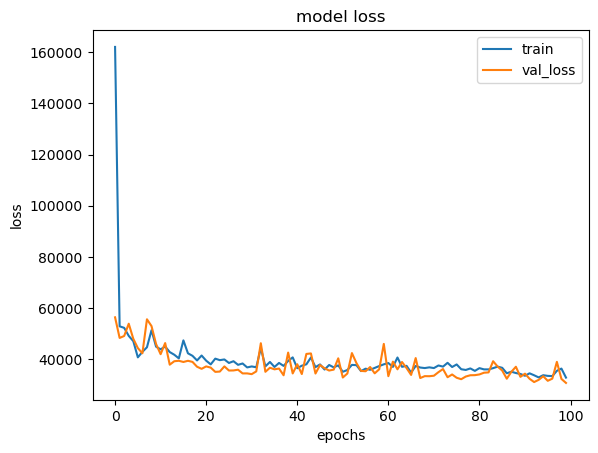

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val_loss'])
plt.show()

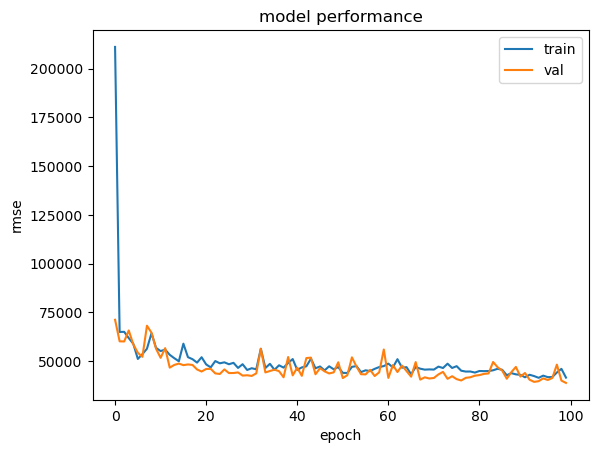

In [101]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [102]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 33395.1211 - root_mean_squared_error: 41259.1992


[33395.12109375, 41259.19921875]

In [103]:
model.predict(tf.expand_dims(X_test[0], axis = 0 ))

1/1 [==============================] - 0s 98ms/step


array([[226722.98]], dtype=float32)

In [104]:
y_true = list(y_test[:,0].numpy())

In [105]:
y_pred = list(model.predict(X_test)[:,0])

4/4 [==============================] - 0s 2ms/step


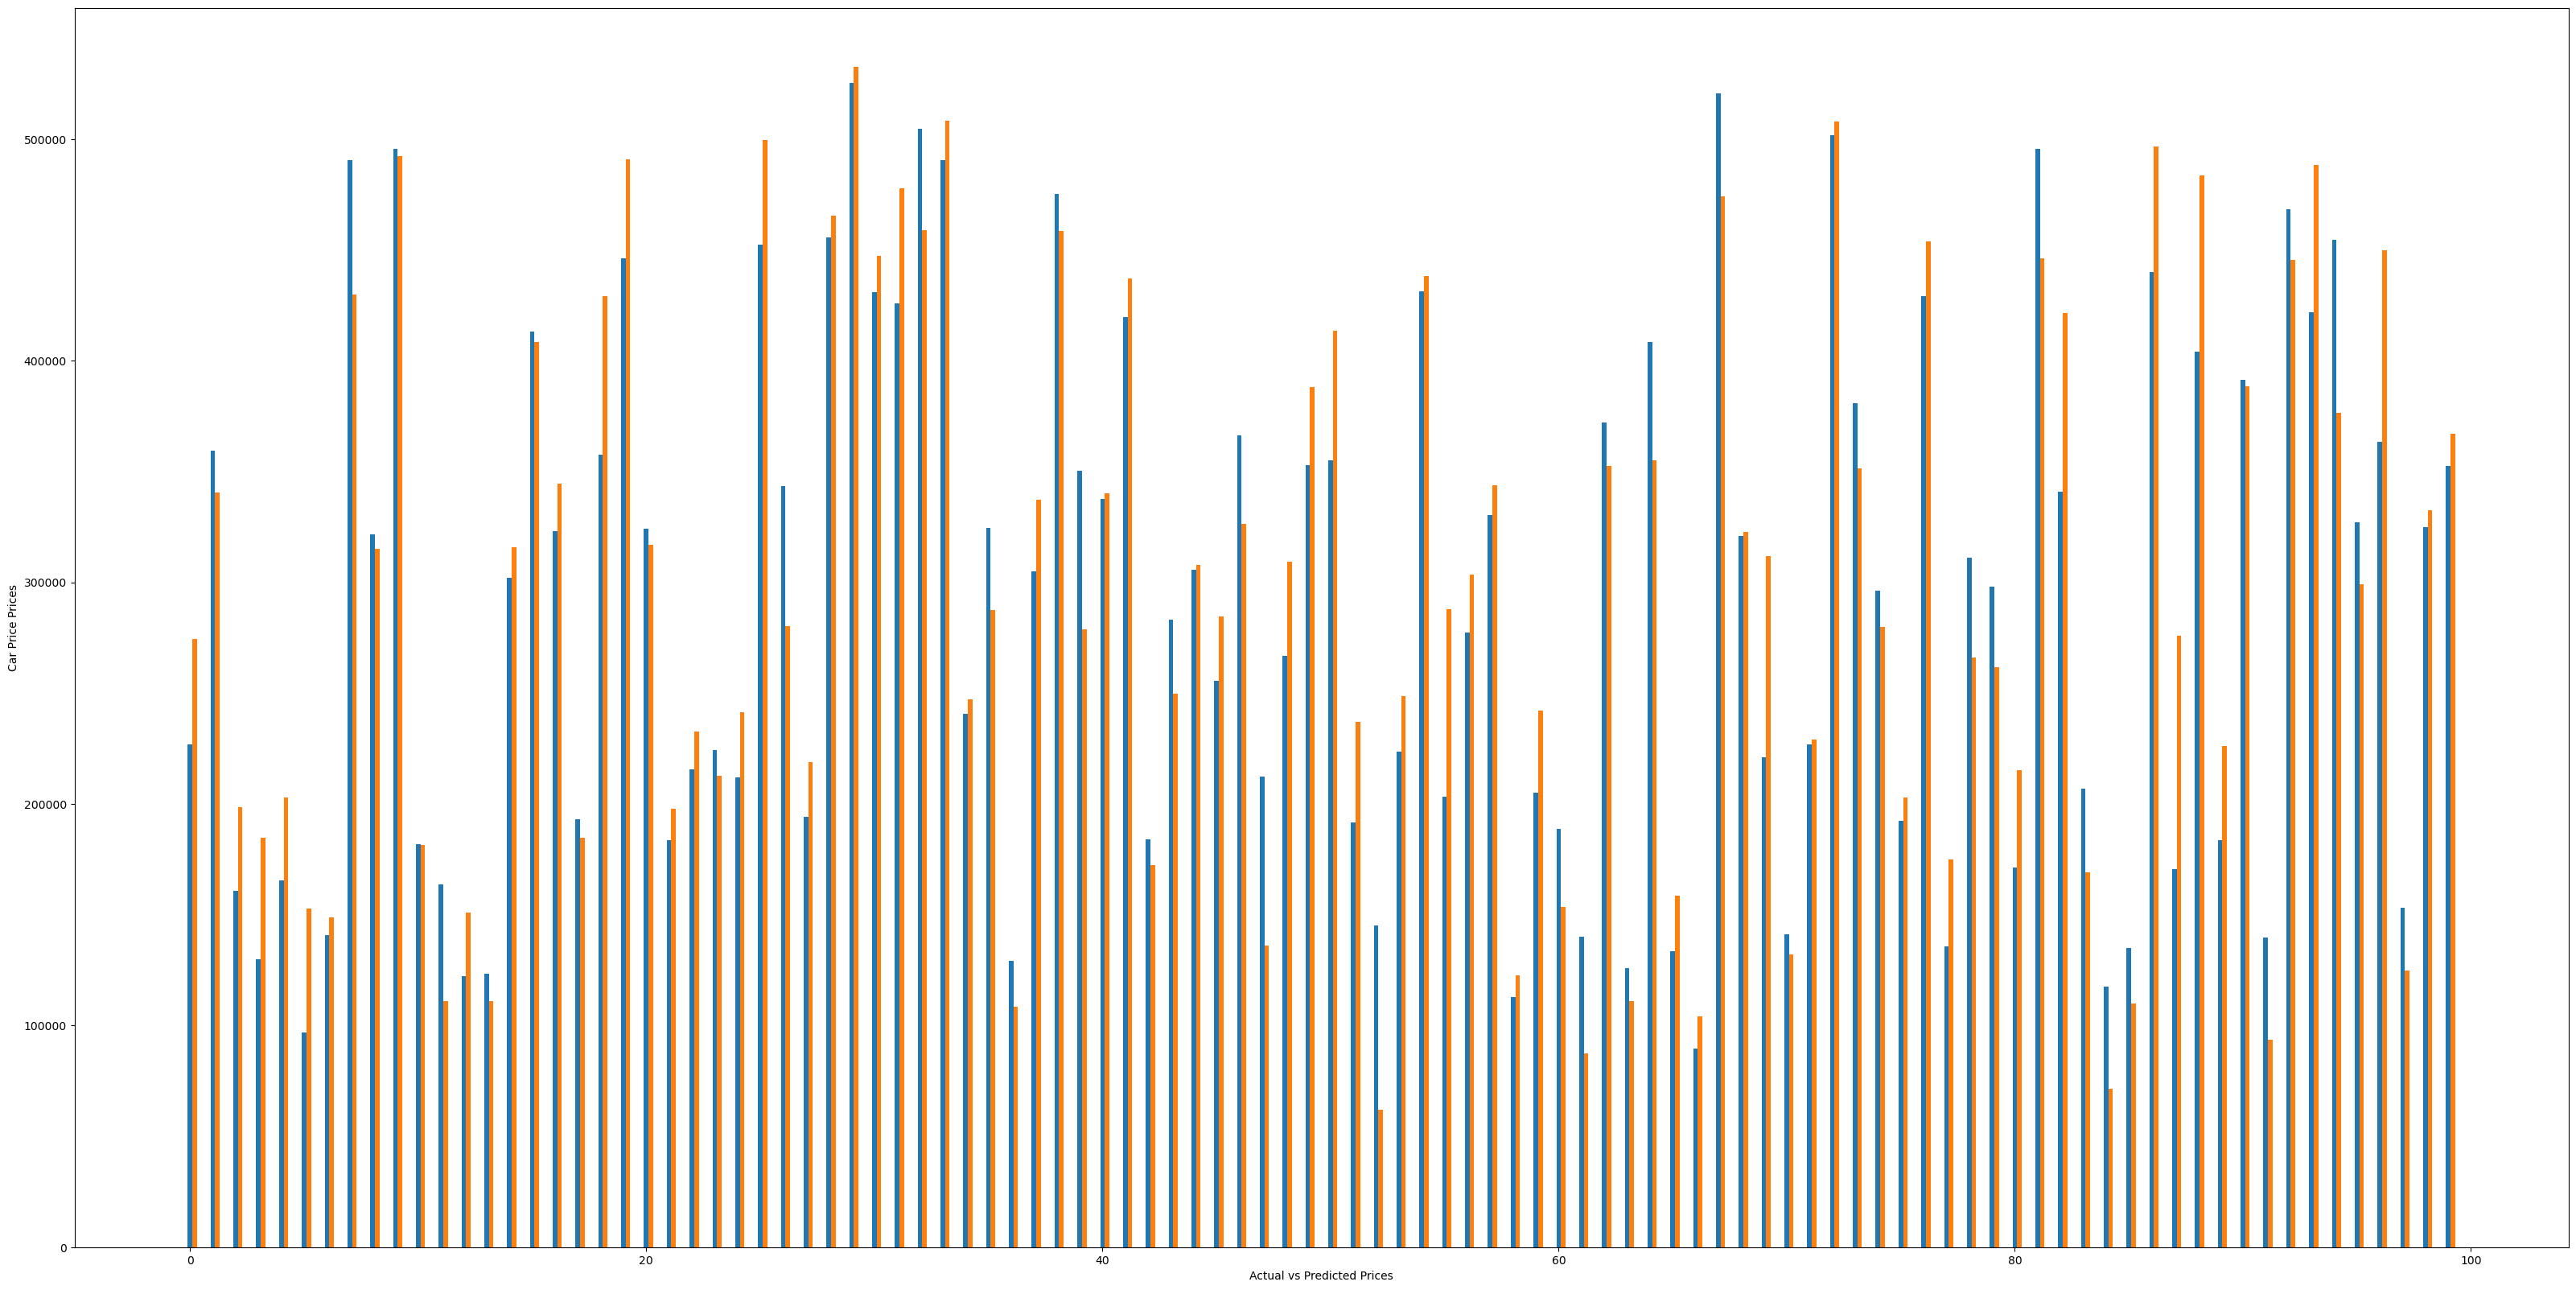

In [106]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.2

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()